# Estimate the confirmed covid-19-cases in Germany for up to 4 weeks in future with LGBM and Keras

- based on global (country/region-wise) developments of confirmation rates including covid_19 and sars_03 outbreaks
- Updated on 20-03-19

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os

from matplotlib import pyplot as plt

### Gather Covid_19 and Sars_2003 data

SARS 2003 outbreak seems to have much in common with current COVID-19 outbreak. Hence, use additional SARS data for training.

In [2]:
#df_covid_19 = pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv')
df_covid_19 = pd.read_csv("../input/novel-corona-virus-2019-dataset/covid_19_data.csv")
df_covid_19['Date'] = pd.to_datetime(df_covid_19['ObservationDate'])
df_covid_19['Outbreak'] = 'COVID_2019'
df_covid_19.columns

Index(['SNo', 'ObservationDate', 'Province/State', 'Country/Region',
       'Last Update', 'Confirmed', 'Deaths', 'Recovered', 'Date', 'Outbreak'],
      dtype='object')

In [3]:
df_sars_03 = pd.read_csv("../input/sars-outbreak-2003-complete-dataset/sars_2003_complete_dataset_clean.csv")
df_sars_03['Date'] = pd.to_datetime(df_sars_03['Date'])
df_sars_03['Province/State'] = None
df_sars_03['Outbreak'] = 'SARS_2003'
print(df_sars_03.columns)
df_sars_03.rename({'Cumulative number of case(s)':'Confirmed', 'Number of deaths':'Deaths', 'Number recovered':'Recovered', 'Country':'Country/Region'},axis=1,inplace=True)

Index(['Date', 'Country', 'Cumulative number of case(s)', 'Number of deaths',
       'Number recovered', 'Province/State', 'Outbreak'],
      dtype='object')


In [4]:
#templ_cols = ['Outbreak', 'Province/State', 'Country/Region', 'Date', 'Confirmed', 'Deaths', 'Recovered']
df = df_covid_19
df = df.reset_index(drop=True)

In [5]:
df['Confirmed'] = df['Confirmed'].fillna(0)
df['Province/State'] = df['Province/State'].fillna('Others')
df = df.sort_values(['Country/Region','Province/State','Date'])

**Addition: We will not focus on provice level because earlier runs showed unsteadiness - not enough data**

Hence: group on country

In [6]:
df = df.groupby(['Outbreak','Country/Region','Province/State','Date']).agg({'Confirmed':'sum'}).reset_index()
df['Province/State'] = 'all'

### Remove countries with minor confirmation numbers

In [7]:
t = df.groupby(['Outbreak','Country/Region','Province/State']).agg({'Confirmed':'max'})
t = t.loc[t['Confirmed'] > 50]
df = pd.merge(df,t[[]],left_on=['Outbreak','Country/Region','Province/State'], right_index=True)

In [8]:
df['Country/Region'].value_counts()

US                    3250
Mainland China        2753
Canada                 660
Australia              548
France                 422
                      ... 
Mali                    26
Diamond Princess        26
West Bank and Gaza      25
Burma                   24
Guadeloupe               9
Name: Country/Region, Length: 147, dtype: int64

In [9]:
country_data = pd.read_csv("../input/countries-of-the-world/countries of the world.csv")
country_data['Country'] = country_data['Country'].str.strip()
country_data

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,NaN,"145,2","16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63"
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",NaN,NaN,NaN,NaN,NaN,"0,02",0,"99,98",1,NaN,NaN,NaN,NaN,"0,4"
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2","37,2","2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393"
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6","8,2","7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489"


In [10]:
df.loc[df['Country/Region']=='US','Country/Region'] = 'United States'
df.loc[df['Country/Region']=='Mainland China','Country/Region'] = 'China'
df.loc[df['Country/Region']=='Viet Nam','Country/Region'] = 'Vietnam'
df.loc[df['Country/Region']=='UK','Country/Region'] = 'United Kingdom'
df.loc[df['Country/Region']=='South Korea','Country/Region'] = 'Korea, South'
df.loc[df['Country/Region']=='Taiwan, China','Country/Region'] = 'Taiwan'
df.loc[df['Country/Region']=='Hong Kong SAR, China','Country/Region'] = 'Hong Kong'

df = pd.merge(df, country_data, how='left', left_on=['Country/Region'], right_on=['Country'])
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df.loc[df['Country'].isnull()]['Country/Region'].value_counts()

North Macedonia           54
Others                    46
Bosnia and Herzegovina    46
Ivory Coast               41
Congo (Kinshasa)          40
Trinidad and Tobago       37
Congo (Brazzaville)       36
Montenegro                34
Kosovo                    32
Cabo Verde                31
Bahamas                   29
Diamond Princess          26
West Bank and Gaza        25
Name: Country/Region, dtype: int64

In [12]:
df.loc[df['Region'].isnull(), 'Region'] = 'Others'
df.loc[df['Country'].isnull(), 'Country'] = 'Undefined'

In [13]:
df['Country'].value_counts()

United States    3250
China            2753
Canada            660
Australia         548
Undefined         477
                 ... 
Uganda             30
Libya              27
Mali               26
Burma              24
Guadeloupe          9
Name: Country, Length: 135, dtype: int64

Check for a proper normalization in case of an LSTM model

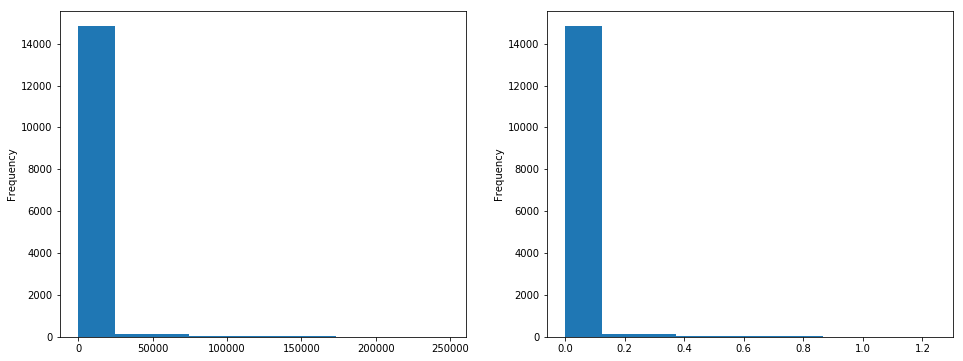

In [14]:
fix, ax = plt.subplots(figsize=(16,6), ncols=2)
s0 = df['Confirmed']
s0.plot.hist(ax=ax[0])

# BoxCox
#from sklearn.preprocessing import PowerTransformer
#transformer = PowerTransformer(method='box-cox', standardize=True)
#s0 = s0+1

# Normalise and reshape
#from sklearn.preprocessing import FunctionTransformer
#transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)

from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler(feature_range=(0,1)).fit(np.asarray([0, 2E5]).reshape(-1,1)) # df['Confirmed'].values.reshape(-1,1)

s1 = pd.Series(transformer.transform(s0.values.reshape(-1,1)).reshape(-1))
s1.plot.hist(ax=ax[1])
df['Confirmed_transformed'] = s1 # make sure that every value is positive

### Feature engineering

In [15]:
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.week

**Lags**

We use a 5-day-lag window to estimate the future development

In [16]:
n_lags = 5
for k,v in df.groupby(['Outbreak','Country/Region','Province/State']):    
    for d in range(n_lags,0,-1):                
        df.loc[v.index, f'Confirmed_Lag_{d}'] = v['Confirmed'].shift(d)
        #df.loc[v.index, f'Confirmed_Rolling_Mean_Lag{d}'] = v['Confirmed'].shift(d).rolling(n_lags).mean()
        df.loc[v.index, f'Confirmed_Transformed_Lag_{d}'] = v['Confirmed_transformed'].shift(d)

X_mask_lags = [c for c in df.columns if 'Confirmed_Lag_' in c]# + [c for c in df.columns if 'Confirmed_Rolling_Mean_Lag' in c]
X_mask_lags_transformed = [c for c in df.columns if 'Confirmed_Transformed_Lag_' in c]

df[X_mask_lags] = df[X_mask_lags].fillna(0)
df[X_mask_lags_transformed] = df[X_mask_lags_transformed].fillna(0)

print(f'Dataframe shape {df.shape}')

Dataframe shape (15207, 38)


### Encoding

In [17]:
from sklearn.preprocessing import LabelEncoder
enc_outb = LabelEncoder().fit(df['Outbreak'])
df['Outbreak_enc'] = enc_outb.transform(df['Outbreak'])

enc_ctry = LabelEncoder().fit(df['Country/Region'])
df['Country_enc'] = enc_ctry.transform(df['Country/Region'])

enc_region = LabelEncoder().fit(df['Region'])
df['Region_enc'] = enc_region.transform(df['Region'])

## Machine Learning with LGBM

In [18]:
from sklearn.model_selection import train_test_split

X_mask_cat = ['Outbreak_enc','Region_enc', 'Month','Week']
train_test = df.loc[df['Confirmed'] > 50].copy()
s_unique_values = train_test[X_mask_lags].apply(lambda r: len(np.unique(r.values)), axis=1)
train_test = train_test.loc[s_unique_values > 1].copy()
print(f'Train/Test shape {train_test.shape}')

train, valid = train_test_split(train_test, test_size=0.2, shuffle=True, random_state=231451)

Train/Test shape (8381, 41)


In [19]:
from lightgbm import LGBMRegressor    
model_lgbm = LGBMRegressor(n_estimators=200, metric='mae', random_state=1234, min_child_samples=5, min_child_weight=0.000001)

print(f'Fitting on data with shape {train[X_mask_cat+X_mask_lags].shape} with validation of shape {valid[X_mask_cat+X_mask_lags].shape}')

model_lgbm.fit(X=train[X_mask_cat+X_mask_lags], y=train['Confirmed'], 
               eval_set=(valid[X_mask_cat+X_mask_lags], valid['Confirmed']),
               early_stopping_rounds=50, verbose=10)

Fitting on data with shape (6704, 9) with validation of shape (1677, 9)
Training until validation scores don't improve for 50 rounds
[10]	valid_0's l1: 2600.68
[20]	valid_0's l1: 937.464
[30]	valid_0's l1: 448.15
[40]	valid_0's l1: 332.481
[50]	valid_0's l1: 304.156
[60]	valid_0's l1: 296.314
[70]	valid_0's l1: 291.288
[80]	valid_0's l1: 289.805
[90]	valid_0's l1: 289.52
[100]	valid_0's l1: 289.831
[110]	valid_0's l1: 289.997
[120]	valid_0's l1: 290.637
[130]	valid_0's l1: 290.929
[140]	valid_0's l1: 290.834
Early stopping, best iteration is:
[92]	valid_0's l1: 289.326


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              metric='mae', min_child_samples=5, min_child_weight=1e-06,
              min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
              objective=None, random_state=1234, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

Out-of-sample prediction with 28 steps (days)

In [20]:
from datetime import timedelta
pred_steps = 28

history = df.loc[(df['Outbreak']=='COVID_2019') & (df['Confirmed'] > 0)]
history0 = history.iloc[-1]

dt_rng = pd.date_range(start=history0['Date']+timedelta(days=1), 
                       end=history0['Date']+timedelta(days=pred_steps),freq='D').values
dt_rng = pd.to_datetime(dt_rng)

pred_months = pd.Series(dt_rng).apply(lambda dt: dt.month)
pred_weeks = pd.Series(dt_rng).apply(lambda dt: dt.week)

pred_cat = history0[X_mask_cat].values
pred_lags = history0[X_mask_lags].values
y = history0['Confirmed']

print('History 0: ', pred_lags)
pred_lags[:n_lags] = np.roll(pred_lags[:n_lags], -1)
pred_lags[n_lags-1] = y  # Lag
#pred_lags[n_lags:] = np.roll(pred_lags[n_lags:], -1)
#pred_lags[-1] = np.mean(pred_lags[:n_lags]) # rolling_mean
print('Pred 0: ', pred_lags)

pred = np.zeros(pred_steps)
for d in range(pred_steps):     
    pred_cat[1] = pred_months[d]
    pred_cat[2] = pred_weeks[d]    
    
    y = model_lgbm.predict(np.hstack([pred_cat, pred_lags]).reshape(1,-1))[0]
    #print(f'Prediction body: ', np.hstack([pred_cat, pred_lags]).reshape(1,-1))
    print(f'Step {d}, predicted for {dt_rng[d].strftime("%Y-%m-%d")} is: {y}')
    
    pred_lags[:n_lags] = np.roll(pred_lags[:n_lags], -1)
    pred_lags[n_lags-1] = y  # Lag    
 #   pred_lags[n_lags:] = np.roll(pred_lags[n_lags:], -1)
 #   pred_lags[-1] = np.mean(pred_lags[n_lags:]) # rolling_mean

    pred[d] = y
    
preds = pd.Series(data=pred, index=dt_rng, name='LGBM predicted')

History 0:  [162488.0 165155.0 168941.0 172434.0 175925.0]
Pred 0:  [165155.0 168941.0 172434.0 175925.0 178972.0]
Step 0, predicted for 2020-04-20 is: 217925.58463382538
Step 1, predicted for 2020-04-21 is: 217925.58463382538
Step 2, predicted for 2020-04-22 is: 217925.58463382538
Step 3, predicted for 2020-04-23 is: 217925.58463382538
Step 4, predicted for 2020-04-24 is: 217925.58463382538
Step 5, predicted for 2020-04-25 is: 217925.58463382538
Step 6, predicted for 2020-04-26 is: 217925.58463382538
Step 7, predicted for 2020-04-27 is: 217925.58463382538
Step 8, predicted for 2020-04-28 is: 217925.58463382538
Step 9, predicted for 2020-04-29 is: 217925.58463382538
Step 10, predicted for 2020-04-30 is: 217925.58463382538
Step 11, predicted for 2020-05-01 is: 218081.4742886328
Step 12, predicted for 2020-05-02 is: 218081.4742886328
Step 13, predicted for 2020-05-03 is: 218081.4742886328
Step 14, predicted for 2020-05-04 is: 218081.4742886328
Step 15, predicted for 2020-05-05 is: 218081

## Machine Learning via Neural network (KERAS-based)

Use a model which is comprising some categorical informations (via embedding layers) and a LSTM structure to learn the time-dependent behavior.

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector, Input, Concatenate, Flatten, Reshape, Embedding
from tensorflow.keras.backend import clear_session

clear_session()

inp_outbreak = Input(shape=(1,1))
inp_country = Input(shape=(1,1))
inp_lags = Input(shape=(n_lags,1))

emb_outbreak = Embedding(input_dim=2, output_dim=1)(inp_outbreak)
emb_country = Embedding(input_dim=210, output_dim=2)(inp_country)

lstm1 = LSTM(64, activation='linear', return_sequences=True)(inp_lags)
lstm2 = LSTM(32, activation='linear', return_sequences=False)(lstm1)

concat1 = Reshape(target_shape=(1,3))(Concatenate(axis=3)([emb_outbreak, emb_country]))
concat2 = Concatenate(axis=1)([Flatten()(concat1), lstm2])
dense1 = Dense(32, activation='linear')(concat2)
dense2 = Dense(1, activation='linear')(dense1)

model_keras = Model(inputs=[inp_outbreak, inp_country, inp_lags], outputs=[dense2])
model_keras.compile(loss='mean_squared_error', optimizer='adam')
model_keras.summary()


def prepare_keras_input(data):
    lags = data[X_mask_lags_transformed].values.reshape(-1, 5, 1)
    y = data['Confirmed_transformed'].values.reshape(-1,1)    
    
    return [data['Outbreak_enc'].values.reshape(-1,1,1), 
            data['Country_enc'].values.reshape(-1,1,1), lags], y
    
train_X, train_y = prepare_keras_input(train)
model_keras.fit(train_X, train_y, validation_data=(prepare_keras_input(valid)), epochs=50, verbose=0)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 1, 1)      2           input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 1, 2)      420         input_2[0][0]                    
______________________________________________________________________________________________

Out-of-sample prediction with 28 steps (days)

In [22]:
from datetime import timedelta
from tensorflow import convert_to_tensor

pred_steps = 28

history = df.loc[(df['Outbreak']=='COVID_2019') & (df['Confirmed'] > 0)]
history0 = history.iloc[-1]

pred_cat_outbreak = convert_to_tensor(history0['Outbreak_enc'].reshape(-1,1,1), np.int32)
pred_cat_country = convert_to_tensor(history0['Country_enc'].reshape(-1,1,1), np.int32)

pred_lags = history0[X_mask_lags_transformed].values
y = history0['Confirmed_transformed']

#print('History 0: ', pred_lags)
pred_lags = np.roll(pred_lags, -1)
pred_lags[-1] = y

#print('Pred 0: ', pred_lags)
pred = np.zeros(pred_steps)

dt_rng = pd.date_range(start=history0['Date']+timedelta(days=1), 
                       end=history0['Date']+timedelta(days=pred_steps),freq='D').values
dt_rng = pd.to_datetime(dt_rng)
# Scale
for d in range(pred_steps):    
    y = model_keras.predict([pred_cat_outbreak, pred_cat_country, convert_to_tensor(pred_lags.reshape(-1,5,1), np.float32)])[0][0]
    #print(f'Pred body: {pred_lags}')
    print(f'Step {d}, predicted for {dt_rng[d].strftime("%Y-%m-%d")} is: {transformer.inverse_transform(y.reshape(-1,1)).reshape(-1)}')
    
    pred_lags = np.roll(pred_lags, -1)
    pred_lags[-1] = y    
    pred[d] = y
    
pred = transformer.inverse_transform(pred.reshape(-1,1)).reshape(-1)
preds_keras = pd.Series(data=pred, index=dt_rng, name='Keras predicted')

Step 0, predicted for 2020-04-20 is: [182238.66]
Step 1, predicted for 2020-04-21 is: [185558.94]
Step 2, predicted for 2020-04-22 is: [188970.88]
Step 3, predicted for 2020-04-23 is: [192482.2]
Step 4, predicted for 2020-04-24 is: [196085.08]
Step 5, predicted for 2020-04-25 is: [199782.83]
Step 6, predicted for 2020-04-26 is: [203575.39]
Step 7, predicted for 2020-04-27 is: [207463.86]
Step 8, predicted for 2020-04-28 is: [211449.67]
Step 9, predicted for 2020-04-29 is: [215534.4]
Step 10, predicted for 2020-04-30 is: [219719.89]
Step 11, predicted for 2020-05-01 is: [224008.02]
Step 12, predicted for 2020-05-02 is: [228400.75]
Step 13, predicted for 2020-05-03 is: [232900.23]
Step 14, predicted for 2020-05-04 is: [237508.66]
Step 15, predicted for 2020-05-05 is: [242228.3]
Step 16, predicted for 2020-05-06 is: [247061.47]
Step 17, predicted for 2020-05-07 is: [252010.61]
Step 18, predicted for 2020-05-08 is: [257078.27]
Step 19, predicted for 2020-05-09 is: [262267.03]
Step 20, pred

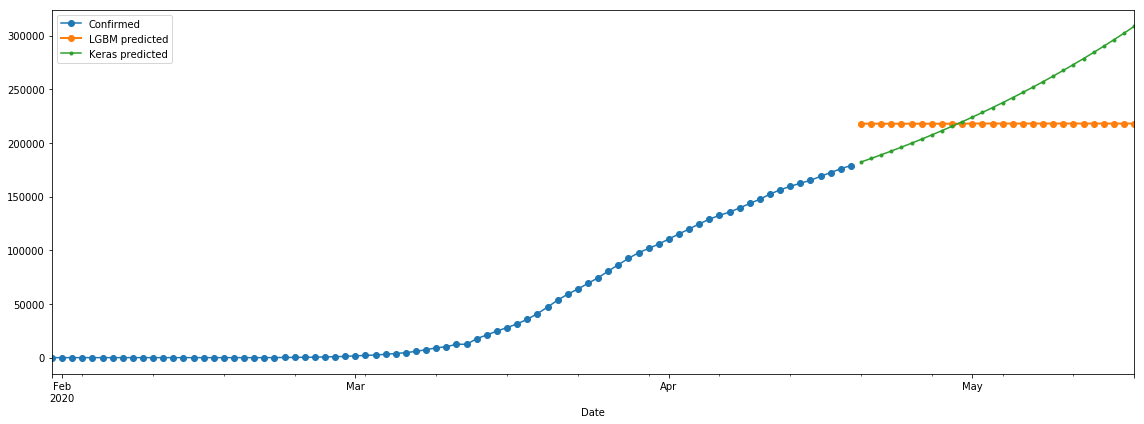

In [23]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(16,6))

hist = history.set_index(['Date'])['Confirmed'].plot(ax=ax, marker='o')
preds.plot(ax=ax, marker='o', linewidth=2)
preds_keras.plot(ax=ax, marker='.')
plt.legend()
plt.tight_layout()


### Save results

In [24]:
ts = datetime.datetime.now().strftime('%Y%m%d')
df_out = pd.DataFrame([preds, preds_keras]).T
df_out.to_csv(f'{ts}_prediction.csv')